# **Note on using the program:**
*   Для удобства пользования программа разбита на блоки, каждый из которых выполняет свой набор задач;
*   Не все блоки программы являются обязательными к запуску для корректной работы программы, такие блоки помечаются, как: "(optional)";

>**Для безопасного и правильного использования программы - просматривайте описания для блоков перед их запуском.**

**Block 1:** Подключение необходимых библиотек, установка random seed для воспроизводимости эксперимента.

In [ ]:
!pip install gdown

import tensorflow as tf # Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt # Plotting and Model Evaulation Libraries
import IPython.display as ipd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import zipfile # Дополнение для работы с архивом фотографий
import gdown # Библиотека, что позволяет быстро получить доступ к данным хранимым на google grive
import numpy as np
import cv2
import os # Библиотека для работы с папками

keras.utils.set_random_seed(47)

**Block 2:** Загрузка и распаковка датасета.

In [ ]:
gdown.download("https://docs.google.com/uc?id=1eUpsSI7LNPC842gKYijA0oLCj2tqT0ep", "img_music.zip", quiet=False) #Датасет доступен по ссылке

original_zip = zipfile.ZipFile('/content/img_music.zip')
original_zip.extractall('/content')
original_zip.close()

Downloading...
From (original): https://docs.google.com/uc?id=1eUpsSI7LNPC842gKYijA0oLCj2tqT0ep
From (redirected): https://docs.google.com/uc?id=1eUpsSI7LNPC842gKYijA0oLCj2tqT0ep&confirm=t&uuid=490fc150-3205-4be8-9acc-85b2b8da84ac
To: /content/img_music.zip
100%|██████████| 75.6M/75.6M [00:05<00:00, 14.0MB/s]


**Block 2.1 (optional):** Загрузка обученных моделей.
> Данный block является необязательным для выполнения, в случае, если вы хотите непосредственно пройти самостоятельно весь процесс обучения модели. Он позволяет загрузить результаты работы программы, а именно две обученные модели предсказания жанра по изображению спектрограммы, без необходимости выполнения кода, в котором происходит обучение, говоря просто - предоставляет  доступ к результатам сразу.

> **В случае, если вы использовали block 2.1 - следует запустить block 3 и сразу переходить к оценке результатов: block 9 и block 10.**

In [ ]:
gdown.download("https://docs.google.com/uc?id=14-IaMAHX7W7Qe_Hx1uTy1TKlQT-9sjFk", "Music_Classification_VGG16_180.h5", quiet=False) # Доступ к файлам моделей по ссылке
gdown.download("https://docs.google.com/uc?id=1s5roWlxJgDWU03Lv59YbKBv0GE4G7rD_", "Music_Classification_VGG16_224.h5", quiet=False)

model = tf.keras.models.load_model("/content/Music_Classification_VGG16_180.h5") # Входное изображение размером 180*180 пикселей
#model = tf.keras.models.load_model("/content/Music_Classification_VGG16_224.h5") # Входное изображение размером 224*224 пикселей

Downloading...
From (original): https://docs.google.com/uc?id=14-IaMAHX7W7Qe_Hx1uTy1TKlQT-9sjFk
From (redirected): https://docs.google.com/uc?id=14-IaMAHX7W7Qe_Hx1uTy1TKlQT-9sjFk&confirm=t&uuid=b34b0c29-8848-46d3-b23e-4bbede2c7790
To: /content/Music_Classification_VGG16_180.h5
100%|██████████| 113M/113M [00:02<00:00, 47.2MB/s]
Downloading...
From (original): https://docs.google.com/uc?id=1s5roWlxJgDWU03Lv59YbKBv0GE4G7rD_
From (redirected): https://docs.google.com/uc?id=1s5roWlxJgDWU03Lv59YbKBv0GE4G7rD_&confirm=t&uuid=e3a1b3bd-8e75-4d74-aa2a-8a4487de9665
To: /content/Music_Classification_VGG16_224.h5
100%|██████████| 139M/139M [00:02<00:00, 62.8MB/s]


**Block 3:** Предобработка данных.

> В данном блоке производится подготовка данных для обучения:
* Задается масштабирование для изображений входящих в датасет;
* Исходный датасет изображений разбивается на 9 частей, по 111 изображений в каждой (т.к. всего 999 изображений, такое разбиение кажется приемлимым);
* Семь батчей (всего 777 изображений) переходят в обучающую выборку, оставшиеся 2 части составляют, в отдельности, валидационную и тестовую выборки.

In [ ]:
training_images_filepath = "/content/Data/images_original"
category_labels = os.listdir(training_images_filepath)

# Задаем масштабирование для спектрограмм
xdim, ydim = 180, 180 # Входное изображение размером 180*180 пикселей
#xdim, ydim = 224, 224 # Входное изображение размером 224*224 пикселей

spectograms = image_dataset_from_directory(
    training_images_filepath,
    image_size = (xdim, ydim),
    batch_size = 111)

# num_batches — 2 пакета для обучения, 1 пакет для проверки, 1 пакет для тестирования
num_batches = tf.data.experimental.cardinality(spectograms).numpy()
train = spectograms.take(num_batches - 2).cache()
remaining = spectograms.skip(num_batches - 2)
validation = remaining.take(1).cache()
test = remaining.skip(1).cache()

Found 999 files belonging to 10 classes.


**Block 4 (optional):** Вывод первых пяти спектрограмм из набора валидации, для ознакомления с используемыми данными.

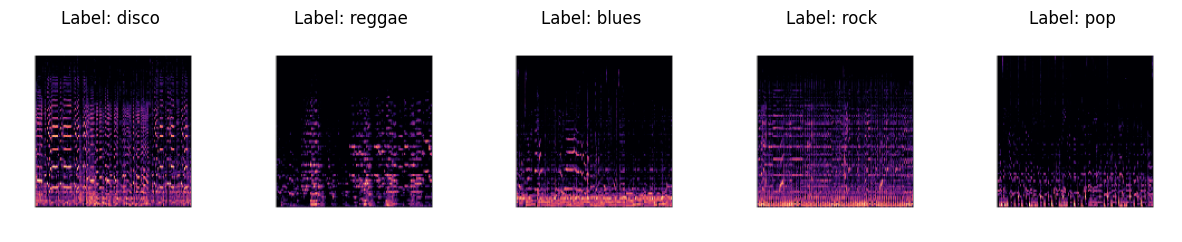

In [ ]:
for images, labels in validation:
    plt.figure(figsize=(15, 500))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {category_labels[labels[i].numpy()]}")
        plt.axis("off")
    plt.show()

#Block 5, Block 6, Block 7 and Block 8: Создание, обучение и сохранение модели.

**Block 5:** Инициализация модели.
> В данном блоке происходит инициализация предобученной модели, в качестве коей выступает VGG16, обученная на датасете изображений imagenet. Однако мы не берем готовую модель, а лишь используем ее как основу в эксперименте, заменив ее классификатор на обученный уже нами. Подобный подход называют *переносом обучения*.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (xdim, ydim, 3))
conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

**Block 6:** Обучение собственного классификатора.
> На данном этапе производятся следующие действия:
* Замораживаются слои предварительно обученной модели, чтобы не менять их веса при обучении на новых данных;
* Определяется новая "голова" модели, которая будет добавлена к замороженному телу. Новая "голова" включает в себя полносвязный слой с 256 нейронами и функцией активации ReLU, а также выходной слой с количеством нейронов, соответствующим количеству категорий (10), и функцией активации softmax;
* Создается модель, состоящая из входных данных и добавленной "головы";
* Модель компилируется с функцией потерь sparse_categorical_crossentropy, оптимизатором rmsprop.

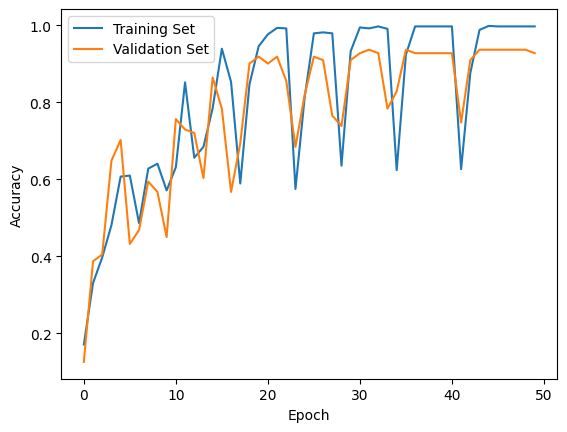

In [ ]:
conv_base.trainable = False # Заморозка предобученных слоёв

# Создание новой головы
inputs = keras.Input(shape=(xdim, ydim, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
outputs = layers.Dense(len(category_labels), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 50,
    validation_data = validation,
    verbose = 0)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

**Block 7:** Тонкая настройка модели.
> В предыдушем шаге было проведено умеренное обучение классификатора для модели. В дальнейшем, для более тонкой настройки и повышения качества мы разморозим последнии 4 слоя модели и обучим их вместе с классификатором, Подобный подход может улучшить имеющиеся результаты и лучше адаптировать модель к "пониманию" наших данных.

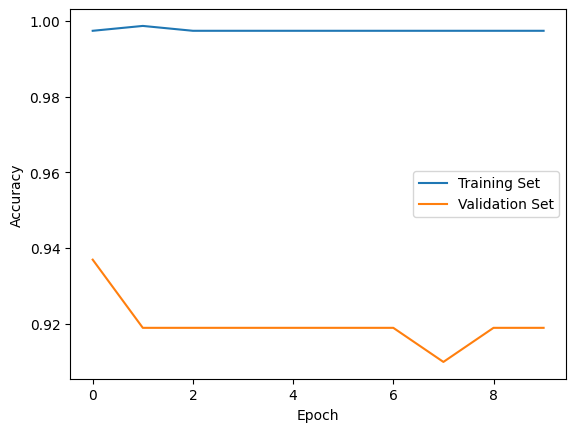

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    verbose = 0)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

**Block 8:** Выгрузка полученных результатов.

In [ ]:
# Сохранение обученной модели в виде файла
model.save('Music_Classification_VGG16_180.h5') # Входное изображение размером 180*180 пикселей
#model.save('Music_Classification_VGG16_224.h5') # Входное изображение размером 224*224 пикселей

#Block 9 and Block 10: Оценивание результатов.


**Block 9:** Расчёт точности модели на тестовых данных.

In [ ]:
predictions_prob = model.predict(test)
predictions = np.argmax(predictions_prob, axis = 1)

ground_truth = [label for _, label in test.unbatch()]
ground_truth = tf.stack(ground_truth, axis = 0).numpy()

accuracy = accuracy_score(ground_truth, predictions)
print("Accuracy of the model:", accuracy)

1/1 [==============================] - 15s 15s/step
Accuracy of the model: 0.9369369369369369


**Block 10:** Вывод матрицы путаницы.


Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.94      1.00      0.97        16
           2       0.80      0.80      0.80        10
           3       0.88      0.88      0.88         8
           4       1.00      0.93      0.96        14
           5       1.00      1.00      1.00        10
           6       1.00      0.92      0.96        13
           7       0.83      0.83      0.83         6
           8       1.00      1.00      1.00        11
           9       0.94      0.94      0.94        16

    accuracy                           0.94       111
   macro avg       0.93      0.93      0.93       111
weighted avg       0.94      0.94      0.94       111



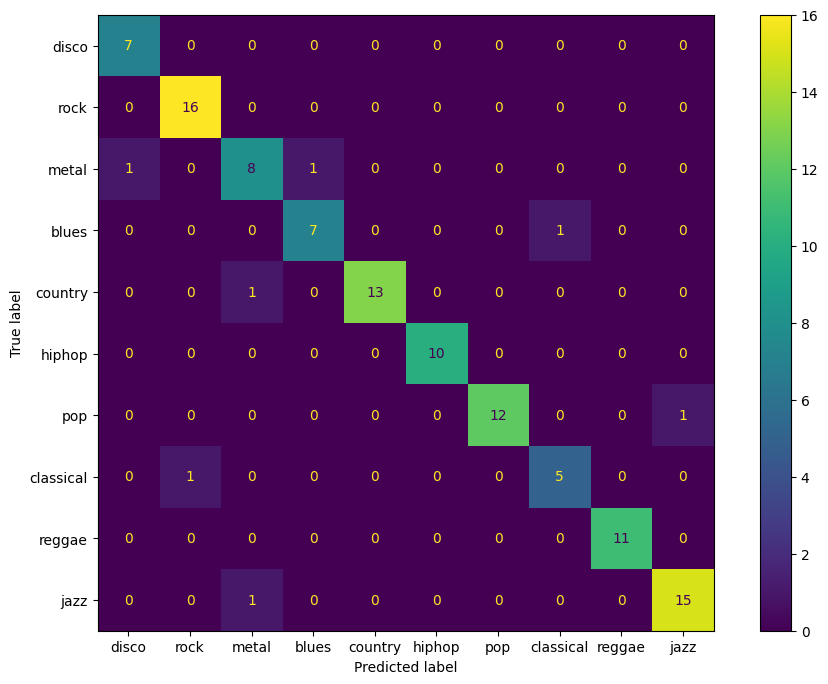

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
conf_matrix = confusion_matrix(ground_truth, predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels = category_labels).plot(ax = ax)

report = classification_report(ground_truth, predictions)
print('\nClassification Report:\n', report)

**Block 11:** Испытание модели на загруженной спектрограмме.

In [ ]:
image = cv2.imread("/content/Data/images_original/hiphop/hiphop00003.png") # Загрузка изображения, указывать путь до нужного файла

music_genres = { # Структура для конфертации меток классов в названия жанров
    0:"blues", 1:"classical", 2:"country", 3:"disco", 4:"hiphop",
    5: "jazz", 6:"metal", 7:"pop", 8:"reggae", 9:"rock"}

image = cv2.resize(image, (180,180)) # Масштабируем изображение до нужного входного размера
array_predictions = model.predict(np.array([image])) # Предсказываем, получаем массив вероятностей, где наибольшее число ссответствует предсказанному классу
predict_class = np.argmax(array_predictions) # узнаем номер наибольшего элемента в массиве - это будет метка предсказанного класса

print(f"На загруженном изображении представлена песня из жанра {music_genres[predict_class]}") # соотносим метку класса с названием и выводим сообщение о жанре

1/1 [==============================] - 1s 1s/step
На загруженном изображении представлена песня из жанра hiphop


# **Results:**
>**В данном эксперименте были разработаны две модели на основе переноса обучения, в качестве исходной обученной модели использовалась VGG16. Основное различие моделей связано с размером принимаемого на вход изображения, так, одна из моделей, далее модель-1, имела размер входного изображения 180x180 пикселей, а другая, далее модель-2, 224x224. В ходе эксперимента, было выяснено, что модель-1 и модель-2 являются сопоставимыми по эффективности решениями, с отрывом примерно в пол процента наибольшую точность показала модель-2, что можно объяснить особенностями взятой для переноса обучения модели, так как VGG16 изначально и обчалась на изображениях такого разрашенеия. Однако, вес модели-2 почти на 30% превышает вес модели-1, поэтому в базом сценарии данного эксперимента представлены ее результаты.**

> Для расчета точности и матрицы путаницы модели-2, необходимо внести изменения в block 2.1 и block 3, сняв комментарий со строки с упоминанием 224x224 и добавив его на строку с 180x180.

# **Дополнение для извлечения весов и изучения структуры их каталогов:**

> Перед началом работы с данной группой блоков кода - необходимо запустить блоки 1, 2, 2.1 и 3.

In [ ]:
# Получение весов модели
weights = model.get_weights()

# Запись весов в отдельный архив, для каждого верхнего массива будет заведен файл (в нашем случае их 30)
np.savez('model_weights.npz', *weights)

# Печать весов
print(model.get_weights()) #вывод на экран всей структуры весов

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.056

In [ ]:
# Просмотр интересующих каталогов
#print((model.get_weights()[0][0][0][0])) #Вывод каталога с индексом (макс. глубина каталога 0)
print((model.get_weights()[1])) #Вывод каталога с индексом (макс. глубина каталога 1)

print(len(model.get_weights())) #Длина всего списка весов (так как 30 массивов, то выдает 30)
print(len(model.get_weights()[1])) #Длина первого из 30 массивов
#print(len(model.get_weights()[0][0])) #Длина первого элемента первого массива
#print(len(model.get_weights()[0][0][0])) #Длина первого элемента первого элемента первого массива
#print(len(model.get_weights()[0][0][0][0])) #Длина первого элемента первого элемента первого элемента первого массива



# **Ниже представлен код для правильной выгрузки весов из файла (с сохранением их структуры):**

In [ ]:
data = np.load('model_weights.npz')

# Извлечение весов из файла
weights = []
for key in data.keys():
    weights.append(data[key])

print(weights)

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.056